<a href="https://colab.research.google.com/github/danielajetunmobi/cholatrek-week5/blob/master/classifier_for_Alzheimer's_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
from os import listdir
import pathlib
from random import randint
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from distutils.dir_util import copy_tree, remove_tree


# To  get different metric scores
from sklearn.metrics import (
    confusion_matrix,
    classification_report)
# Tools to help with model building
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:

#importing files from google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading the files
dataset='/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/'

In [4]:
for file in listdir(dataset):
    print(file)

train
test


In [5]:
base_dir = dataset
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))


Working Directory Contents: ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'MildDemented',
            'VeryMildDemented',
            'ModerateDemented']

In [7]:
#genrate more images for train dataset
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=True)


Found 6400 images belonging to 4 classes.


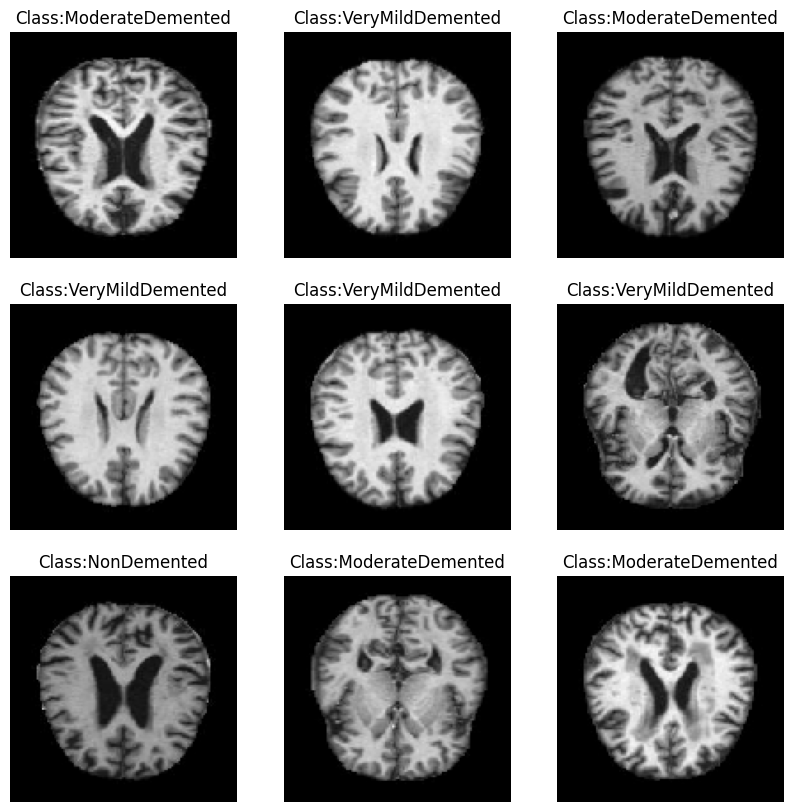

In [8]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)


In [9]:
train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [11]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:


# Create a Sequential model
model = Sequential()

# Block 1
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',  input_shape=(128, 128,3)))
model.add(MaxPooling2D(pool_size=(2, 2),))
BatchNormalization()
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', ))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2), ))
BatchNormalization()
model.add(Dropout(0.2))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                    

In [15]:
# Compile and train the model
tf.random.set_seed(405)
early_stopping =EarlyStopping(monitor="val_loss",
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit( train_data,train_labels,batch_size=32, epochs=50,validation_data=(val_data, val_labels),callbacks=[early_stopping],
          )



Epoch 1/50
256/256 [==============================] - 16s 37ms/step - loss: 1.2601 - accuracy: 0.3477 - val_loss: 0.8293 - val_accuracy: 0.6108
Epoch 2/50
256/256 [==============================] - 9s 34ms/step - loss: 0.7281 - accuracy: 0.6530 - val_loss: 0.6142 - val_accuracy: 0.7227
Epoch 3/50
256/256 [==============================] - 8s 33ms/step - loss: 0.5981 - accuracy: 0.7280 - val_loss: 0.4965 - val_accuracy: 0.7925
Epoch 4/50
256/256 [==============================] - 9s 34ms/step - loss: 0.4812 - accuracy: 0.7910 - val_loss: 0.4001 - val_accuracy: 0.8242
Epoch 5/50
256/256 [==============================] - 9s 34ms/step - loss: 0.3941 - accuracy: 0.8351 - val_loss: 0.3551 - val_accuracy: 0.8525
Epoch 6/50
256/256 [==============================] - 8s 33ms/step - loss: 0.3129 - accuracy: 0.8735 - val_loss: 0.3039 - val_accuracy: 0.8770
Epoch 7/50
256/256 [==============================] - 9s 33ms/step - loss: 0.2572 - accuracy: 0.8994 - val_loss: 0.3173 - val_accuracy: 0.874

<Axes: >

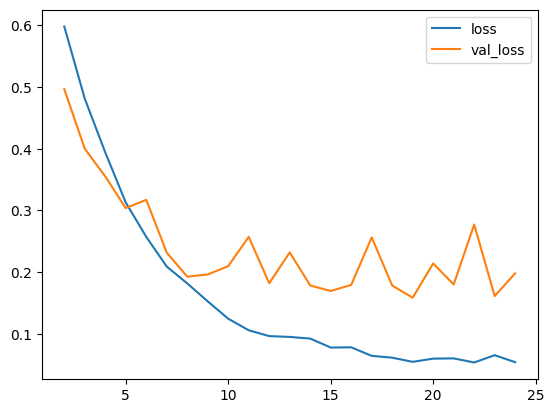

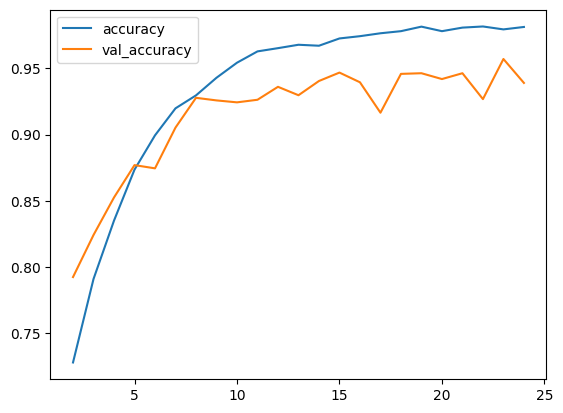

In [16]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 2
history_df.loc[2:, ['loss', 'val_loss']].plot()
history_df.loc[2:,['accuracy','val_accuracy']].plot()

In [17]:
prediction=model.predict(test_data)

80/80 [==============================] - 1s 7ms/step


In [18]:

#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], yticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [19]:
pred= np.argmax(prediction,axis=1)
test=np.argmax(test_labels,axis=1)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       630
           1       1.00      1.00      1.00       634
           2       0.93      0.89      0.91       648
           3       0.90      0.92      0.91       648

    accuracy                           0.95      2560
   macro avg       0.95      0.95      0.95      2560
weighted avg       0.95      0.95      0.95      2560



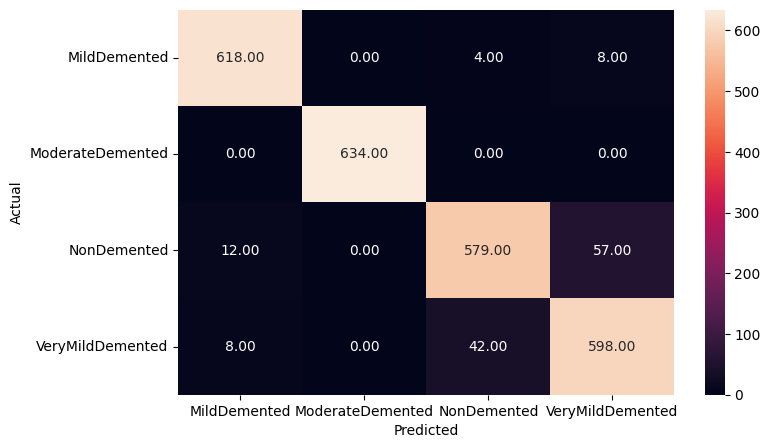

In [20]:
metrics_score(test,pred)